# Exploração inicial dos dados

- Aqui tenho interesse em explorar os dados e entender como estão rotulados


In [18]:
!pip show mask-rcnn
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import skimage.io

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /home/lsanche/anaconda3/envs/uva/lib/python3.6/site-packages/mask_rcnn-2.1-py3.6.egg
Requires: 
Required-by: 


# Script para Consumo do dataset
- Este script tem objetivo de organizar o dataset, juntando os .jpg, .txt e .npz


In [137]:
global_path = '/home/lsanche/Documentos/uva/data/img'
txt_list_paths = list(Path(global_path).glob("*.txt"))
npz_list_paths = list(Path(global_path).glob("*.npz"))
jpg_list_paths = list(Path(global_path).glob("*.jpg"))

bag_ordered_txt = []
bag_ordered_npz = []
for jpg in range(len(jpg_list_paths)):
    a = str(jpg_list_paths[jpg]).split('/')[-1].split('.')[0]
    for txt in range(len(txt_list_paths)):
        b = str(txt_list_paths[txt]).split('/')[-1].split('.')[0]
        if a == b:
            bag_ordered_txt.append(txt)

    for npz in range(len(npz_list_paths)):
        c = str(npz_list_paths[npz]).split('/')[-1].split('.')[0]
        if a == c:
            bag_ordered_npz.append(npz)

txt_ordered_list = [txt_list_paths[i] for i in bag_ordered_txt]
npz_ordered_list = [npz_list_paths[i] for i in bag_ordered_npz]

#print(jpg_list_paths)
#print(txt_ordered_list)

In [138]:
print(jpg_list_paths[0])
print(npz_ordered_list[0])
print(txt_ordered_list[0])

/home/lsanche/Documentos/uva/data/img/CSV_1877.jpg
/home/lsanche/Documentos/uva/data/img/CSV_1877.npz
/home/lsanche/Documentos/uva/data/img/CSV_1877.txt


# Mascaras

- Método para consumir as máscaras .npz
    - Acessa o arquivo .npz
    - Processa as mascaras na forma [:,:,Num_Mascaras]
    - faz o plot rodando nas Num_mascaras

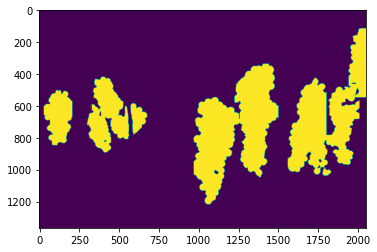

In [139]:
def consume_masks(mask):
    sum_masks = mask.f.arr_0[:,:,0]
    n_channel = mask.f.arr_0.shape[2]
    for i in range(1,n_channel):
        sum_masks += mask.f.arr_0[:,:,i]
    plt.imshow(sum_masks)
    plt.show
    
mask = np.load(npz_ordered_list[0],mmap_mode='r')
consume_masks(mask)

# Exploração das Bounding Box

- Aqui busco transformar os arquivos TXT em Listas com as informações dos Bounding Box

- Percebo, também, que o formato das BB não estão na forma que é consumida pelo mrcnn

In [140]:
a = txt_ordered_list[0]

bag = []
with open(a) as f:
    lines = f.readlines()
    for line in lines:
        b = line.split(' ')[1:]
        b = [float(i) for i in b]
        bag.append(b)
#xmin, ymin, xmax, ymax = b
print(bag)

[[0.5422, 0.6451, 0.1382, 0.4916], [0.9307, 0.5238, 0.0986, 0.3707], [0.6648, 0.5059, 0.1343, 0.5194], [0.8198, 0.5271, 0.1182, 0.4315], [0.8577, 0.6663, 0.0698, 0.1868], [0.2744, 0.5095, 0.1113, 0.1634], [0.0581, 0.4919, 0.0869, 0.2542], [0.2114, 0.4022, 0.0918, 0.1934], [0.9731, 0.2418, 0.0527, 0.3165], [0.1831, 0.5429, 0.0732, 0.2212]]


# Transforma BB no formato do mrcnn

- As Bounding Box estão no formato padrão do YOLO: X_Centro, Y_Centro, Width, Hight.
- As coordenadas também são normalizadas pelo tamanho da imagem.
- Para conversão no formato: xmin, ymin, xmax, ymax, faço a transformação de cada uma delas.
- Plot na imagem para conferir se funcionou

img_shape: (1365, 2048, 3)
xmin: 968 xmax: 1251 ymin: 545 ymax: 1216
xdiff: 283 ydiff: 671
xmin: 1805 xmax: 2007 ymin: 461 ymax: 967
xdiff: 202 ydiff: 506
xmin: 1223 xmax: 1499 ymin: 336 ymax: 1045
xdiff: 276 ydiff: 709
xmin: 1557 xmax: 1799 ymin: 424 ymax: 1013
xdiff: 242 ydiff: 589
xmin: 1685 xmax: 1828 ymin: 782 ymax: 1036
xdiff: 143 ydiff: 254
xmin: 447 xmax: 675 ymin: 583 ymax: 806
xdiff: 228 ydiff: 223
xmin: 30 xmax: 207 ymin: 497 ymax: 844
xdiff: 177 ydiff: 347
xmin: 338 xmax: 526 ymin: 417 ymax: 680
xdiff: 188 ydiff: 263
xmin: 1938 xmax: 2046 ymin: 114 ymax: 546
xdiff: 108 ydiff: 432
xmin: 300 xmax: 449 ymin: 590 ymax: 892
xdiff: 149 ydiff: 302


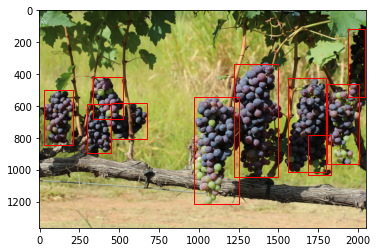

In [141]:
img = skimage.io.imread(jpg_list_paths[0])
x_ = img.shape[1]
y_ = img.shape[0]
print('img_shape: ' + str(img.shape))
fig, ax = plt.subplots()

ax.imshow(img)

for box in range(len(bag)):
    xmin = int((bag[box][0]*x_) - (bag[box][2]* x_)/2)
    ymin = int((bag[box][1]*y_) - (bag[box][3] * y_)/2)
    xmax = int((bag[box][0]*x_) + (bag[box][2] * x_)/2)
    ymax = int((bag[box][1]*y_) + (bag[box][3]*y_)/2)
    #print('xmin:{}, xmax:{},ymin:{},ymax:{} '.format(xmin,xmax,ymin,ymax))
    
    print('xmin: '+ str(xmin) + ' xmax: ' + str(xmax) + ' ymin: '+ str(ymin) + ' ymax: '+ str(ymax))
    xdiff = xmax - xmin
    ydiff = ymax - ymin
    print('xdiff: ' + str(xdiff)+ ' ydiff: ' + str(ydiff))
    
    
    ret = plt.Rectangle((xmin, ymin), xdiff, ydiff, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(ret)

plt.show()
